In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv('RFM_ht_data.csv', parse_dates = ['InvoiceDate'])

/opt/tljh/user/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head()

,InvoiceNo,CustomerCode,InvoiceDate,Amount
0,C0011810010001,19067290,2020-09-01,1716.00
1,C0011810010017,13233933,2020-09-01,1489.74
2,C0011810010020,99057968,2020-09-01,151.47
3,C0011810010021,80007276,2020-09-01,146.72
4,C0011810010024,13164076,2020-09-01,104.00


In [136]:
df.InvoiceNo = df.InvoiceNo.apply(str) # сразу меняю тип данных для исключения недоразумений
df.CustomerCode = df.CustomerCode.apply(str)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332730 entries, 0 to 332729
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   InvoiceNo     332730 non-null  object        
 1   CustomerCode  332730 non-null  object        
 2   InvoiceDate   332730 non-null  datetime64[ns]
 3   Amount        332730 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 10.2+ MB


In [5]:
last_date = df.InvoiceDate.max() # определяю дату последнего заказа
last_date

Timestamp('2020-09-30 00:00:00')

In [7]:
rfmTable = df.groupby('CustomerCode', as_index=False).agg({'InvoiceDate': lambda x: (last_date - x.max()).days, # Recency #Количество дней с последнего заказа
                                        'InvoiceNo': lambda x: len(x),      # Frequency #Количество заказов
                                        'Amount': lambda x: x.sum()}) # Monetary Value #Общая сумма по всем заказам
# создаю новую таблицу с нужными метриками

In [8]:
rfmTable.shape[0] # проверяю количество строк в новой таблице

173086

In [9]:
rfmTable.CustomerCode.nunique() # ...и количество уникальных покупателей

173086

Тут все ок, поэтому идем дальше

In [10]:
rfmTable.rename(columns={'InvoiceDate': 'recency', 
                         'InvoiceNo': 'frequency', 
                         'Amount': 'monetary_value'}, inplace=True)


In [11]:
quantiles = rfmTable.quantile(q=[0.25, 0.5, 0.75])
quantiles # разбиваю каждую колонку новой таблицы на квантили

,recency,frequency,monetary_value
0.25,4.0,1.0,605.2000
0.50,10.0,1.0,1361.7000
0.75,18.0,2.0,2886.6875


In [12]:
rfmSegmentation = rfmTable

Далее создаю функцию, где к каждому значению из колонки подбираю значение соответствующего квартиля, в интервалы которого попало значение.
Для каждой колонки создается новая колонка с соответствующим квартилем (для колонки "recency" - "R_Quartile", для "frequency" - "F_Quartile", для "monetary_value" - "M_Quartile", последняя колонка "RFMClass" будет объединять все предшествующие значения квартилей

In [15]:
def RClass(value,parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 1
    elif value <= quantiles_table[parameter_name][0.50]:
        return 2
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 3
    else:
        return 4


def FMClass(value, parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 4
    elif value <= quantiles_table[parameter_name][0.50]:
        return 3
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 2
    else:
        return 1

In [16]:
rfmSegmentation['R_Quartile'] = rfmSegmentation['recency'].apply(RClass, args=('recency',quantiles))

rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency'].apply(FMClass, args=('frequency',quantiles))

rfmSegmentation['M_Quartile'] = rfmSegmentation['monetary_value'].apply(FMClass, args=('monetary_value',quantiles))

rfmSegmentation['RFMClass'] = rfmSegmentation.R_Quartile.map(str) + rfmSegmentation.F_Quartile.map(str) + rfmSegmentation.M_Quartile.map(str)

In [17]:
rfmSegmentation.head()

,CustomerCode,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
0,2213019,6,1,2161.56,2,4,2,242
1,2213071,7,1,418.00,2,4,4,244
2,2213081,9,1,276.98,2,4,4,244
3,2213082,10,2,1215.96,2,2,3,223
4,2213128,8,2,981.23,2,2,3,223


In [18]:
pd.crosstab(index = rfmSegmentation.R_Quartile, columns = rfmSegmentation.F_Quartile)

F_Quartile,1,2,4
R_Quartile,,,
1,18556,12577,16638
2,11298,11746,19578
3,2813,7558,30721
4,3336,7803,30462


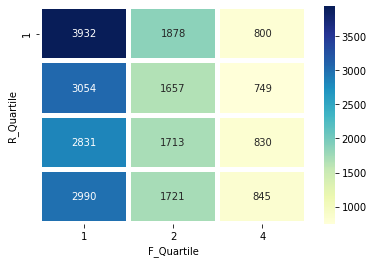

In [20]:
rfm_table = rfmSegmentation.pivot_table(
                        index='R_Quartile', 
                        columns='F_Quartile', 
                        values='monetary_value', 
                        aggfunc=np.median).applymap(int)
sns.heatmap(rfm_table, cmap="YlGnBu", annot=True, fmt=".0f", linewidths=4.15, annot_kws={"size": 10},yticklabels=4);